In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def matrixexponen(n,a):
    #this function is used to do matrix exponentialization
    #this method is usually a bit faster than the usual scipy method this is why I swtiched to it

    q = 6
    a_norm = np.linalg.norm ( a, np.Inf )
    ee = ( int ) ( np.log2 ( a_norm ) ) + 1
    s = max ( 0, ee + 1 )
    a = a / ( 2.0 ** s )
    x = a.copy ( )
    c = 0.5
    e = np.eye ( n, dtype = np.complex64 ) + c * a
    d = np.eye ( n, dtype = np.complex64 ) - c * a
    p = True

    for k in range ( 2, q + 1 ):
        c = c * float ( q - k + 1 ) / float ( k * ( 2 * q - k + 1 ) )
        x = np.dot ( a, x )
        e = e + c * x
        if ( p ):
            d = d + c * x
        else:
            d = d - c * x
        p = not p

    e = np.linalg.solve ( d, e )
    e = np.ascontiguousarray(e)

    for k in range ( 0, s ):
        e = np.dot ( e, e )
    return e

In [46]:
def spin_operators(N):
    #N is the number of spins in the chain
    
    #sigma0
    s0 = np.eye(2, dtype = np.complex128)
    
    #create sigma matrices
    sx = np.matrix([ [0., 1.], 
                     [1., 0.] ], dtype = np.complex128)
    
    sy = np.matrix([ [0., -1.j],
                     [1.j, 0.] ], dtype = np.complex128)
    
    sz = np.matrix([ [1., 0.], 
                     [0., -1.] ], dtype = np.complex128)
    
    #create a container for the spin operators
    #which are of size 2^N * 2^N
    spin_ops = np.zeros((N, 3, 2**N, 2**N), dtype = np.complex128)
    
    #create the tensor product operators that act on the spins in the chain
    #for every spin in the chain
    for i in range(N):
        #copy the 2x2 pauli matrices
        Ox = sx.copy()
        Oy = sy.copy()
        Oz = sz.copy()
        
        #take the kronecker product with the identity for every spin
        #which is on the left side of the spin
        for j in range(i):
            Ox = np.kron(s0, Ox)
            Oy = np.kron(s0, Oy)
            Oz = np.kron(s0, Oz)
        
        #and take kronecker product (from the right) for every spin
        #which is on the right of the spin
        for j in range(i+1,3):
            Ox = np.kron(Ox, s0)
            Oy = np.kron(Oy, s0)
            Oz = np.kron(Oz, s0)            
        
        #now add the operators to the container
        spin_ops[i,0,:,:] = Ox
        spin_ops[i,1,:,:] = Oy
        spin_ops[i,2,:,:] = Oz
        
    return spin_ops

In [47]:
spinops = spin_operators(N=3)

In [48]:
def heis_ham_time_ind(N, J, spinops):
    #return the time independent part of the hamiltonian
    
    #create the hamiltonian
    H0 = np.zeros((2**N,2**N), dtype = np.complex128)
    
    #iterate trough the spins
    for i in range(N-1):
        #add interaction energy to the Hamiltonian
        H0 += - J * ( spinops[i,0,:,:] @ spinops[i+1,0,:,:] + spinops[i,1,:,:] @ spinops[i+1,1,:,:] + spinops[i,2,:,:] @ spinops[i+1,2,:,:] )
    
    #return the time independent part of the hamiltonian
    return H0

In [49]:
def magn_field(h, w, t):
    #returns the instantaneous value of the magnetic field
    #h is the absolute value of the field
    #w is the angular frequency of the field
    #t is the time
    
    bx = h * np.sin(w * t)
    by = 0
    bz = h * np.cos(w * t)
    
    bt = np.array([bx,by,bz], dtype = np.complex128)
    
    #return te vector of the magnetic field
    return bt

In [50]:
def heis_ham_full(H0, spinops, h, w, t):
    #return the full time dependent hamiltonian of the system

    #get the value of the magnetic field
    bt = magn_field(h = h, w = w, t = t)
    
    #add interaction with the magnetic field
    #H_magn = - ( bt_x sigma_x + bt_y sigma_y + bt_z sigma_z )
    #and the sigma operators now correspond to the spin operators of the first spin
    H0 += -1 * ( bt[0] * spinops[0,0,:,:] + bt[1] * spinops[0,1,:,:] + bt[2] * spinops[0,2,:,:] ) 
    
    #return the full time dependent hamiltonian
    return H0

In [51]:
h = 3
w = 2
t = 1


spinops = spin_operators(N = 3)
H0 = heis_ham_time_ind(N = 3, J = 2, spinops = spinops)
Ht = heis_ham_full(H0 = H0, spinops = spinops, h = h, w = w, t = t)

In [52]:
if (Ht - np.conj( Ht.T )).all() == 0:
    print("Hamiltonian is hermitian")

Hamiltonian is hermitian


In [53]:
def vected_comm(N, H):
    
    #now carry out the vectorization of the hamiltonian first
    ii = np.eye(2**N, dtype=np.complex128) #2^N x 2^N identity

    #do vectorization for the commutator of the hamiltonian
    pre = np.kron(ii,H)
    post = np.kron(H,ii)

    #evaluate the commutator
    vected_comm = -1.j*(pre - post)
    #here we dont need to divide by hbar because it is already set to 1 I guess 
    
    return vected_comm

In [54]:
def relaxation_rates(Beta, gammat, esplit):
    
    #find the uphill and downhill relaxation rates
    if Beta == np.inf: #if the temperature is zero then we have only downhill relaxation rate
        gamma1 = gammat
        gamma2 = 0
    else: #otherwise use these rates
        gamma1 = gammat * (1 + 1 / (np.exp(esplit * Beta) - 1))
        gamma2 = gammat / (np.exp(esplit * Beta) - 1)
        
    return gamma1, gamma2

In [55]:
def jump_operators(N, Beta, gammat, esplit):
    #now the jump operator will be a downhill and uphill relaxation towards the y direction
    
    #get the relaxation rates
    gamma1, gamma2 = relaxation_rates(Beta = Beta, gammat = gammat, esplit = esplit)
    
    #sigma0
    s0 = np.eye(2, dtype = np.complex128)
    
    #create sigma_y matrix
    sy = np.matrix([ [0., -1.j],
                     [1.j, 0. ] ], dtype = np.complex128)
    
    #get eigenvectors
    vals, vecs = np.linalg.eig(sy)
    
    #S+ in the y eigenbasis looks like this
    sp_y = np.array([[0.,1.],
                     [0.,0.]], dtype = np.complex128)

    #S- in the y eigenbasis looks like this
    sm_y = np.array([[0.,0.],
                     [1.,0.]], dtype = np.complex128)
    
    #but we need the vector in the Sz basis 
    #so need to do a basis transfomation
    #this is the uphill jump operator
    sp_y_z = np.linalg.inv(vecs) @ (sp_y @ vecs) * np.sqrt(gamma2)
    
    #the downhill jump operator is the conjugate transpose of this
    sm_y_z = np.linalg.inv(vecs) @ (sm_y @ vecs) * np.sqrt(gamma1)
    
    #now we need to construct the two jump operators for the total spin chain
    #for each spin to the left of the final spin on the right 
    for i in range(N-1):
        #add an identity to the operator from the left
        sp_y_z = np.kron(s0, sp_y_z)
        sm_y_z = np.kron(s0, sm_y_z)
    return sp_y_z, sm_y_z

In [56]:
def vectorize_jumpoperator(N, jop):
    #carry out the vectorization for a single jump operator
    
    ii = np.eye(2**N, dtype = np.complex128)
    
    #carry out the vectorization method for a jump operator in the lindbladian
    jop_d = np.conj(jop.T) #dagger of the operator
    
    jdj = jop_d @ jop #operator dagger times the operator
    jdj_t = jdj.T #transpose of the previous product
    
    #first vectorized
    term1 = np.kron(jop.conj(), jop)
    
    #second vectorized
    term2 = np.kron(ii, jdj) + np.kron(jdj_t, ii)    
    
    #return the two terms
    return term1, term2

In [57]:
def vected_jops(N, Beta, gammat, esplit):
    #vectorize the jump operators in the lindblad equation
    
    #create the jump operators
    jop1, jop2 = jump_operators(N = N, Beta = Beta, gammat = gammat, esplit = esplit)
    
    #carry out the vectorization method for both of them
    term11, term12 = vectorize_jumpoperator(N = N, jop = jop1)
    
    term21, term22 = vectorize_jumpoperator(N = N, jop = jop2)
    
    #return the vectorized operators
    return term11, term12, term21, term22

In [59]:
def liouvillians(N, J, h, gammat, esplit, w, Beta, dt, tsu):    
 
    #create a container for the exponentialized operators
    unitary = np.zeros(( 4**N, 4**N, len(tsu) ), dtype=np.complex128)
    
    #create spinoperators
    spinops = spin_operators(N = N)
    
    #create the time independent hamiltonian 
    H0 = heis_ham_time_ind(N = N, J = J, spinops = spinops)
    
    for idx,t in enumerate(tsu):
        
        #create the time dependent hamiltonian
        Ht = heis_ham_full(H0 = H0, spinops = spinops, h = h, w = w, t = t)
        
        #calculate the vectorized form of the commutaton in the lindbladian
        hamil = vected_comm(N = N, H = Ht)
        
        #calculate the vectorized jump operators in the lindblad equation
        term11, term12, term21, term22 =  vected_jops(N = N, Beta = Beta, gammat = gammat, esplit = esplit)
        
        #now put together the total whole Liouvillian
        #pay attention to the 1/2 coefficients
        liouvillian = hamil + term11 - 0.5 * term12 + term21 - 0.5 * term22
        
        #calculate the exponentialized operator
        uu = matrixexponen(4**N,liouvillian*dt)
        
        #add the exponentialized operator to the container
        unitary[:,:,idx] = uu

    return unitary

In [60]:
def time_evolve(N, psi0, unitary, ts, tsu):
    #set psi to the initial state
    psi = psi0.copy()
    
    #collect the time dependent density matrix here
    rhot = np.zeros( (len(ts), 2**N, 2**N) , dtype = np.complex128)
    
    #density matrix for the initial state
    psim = psi.T.reshape((2**N,2**N))
    
    #append it to the density matrix collector
    rhot[0,:,:] = psim

    #carry out the time evolution till the final point
    for idx, t in enumerate(ts[ : -1 ]):
        mat = np.ascontiguousarray(unitary[ : , : , idx%len(tsu) ]) #take the liouvillian at time point t
        
        psi = mat @ psi #time evolve with dt (calculate psi(t+dt))
        
        #construct the density matrix of the state and append the new density matrix to the list
        psim=psi.T.reshape((2**N,2**N))
        rhot[idx+1,:,:] = psim
    
    #return the time dependent density matrices as 2x2 matrices
    return rhot

In [61]:
def transform_state(psi):
    #create the density matrix out of the state psi and then create the vectorized density matrix
    #psi is expected to be a usual numpy array
    
    #make a column vector
    #i.e. create the ket vector
    psi_ket = psi.copy().reshape(-1,1)
    
    #make the density matrix
    #take |psi><psi| 
    #<psi| is the bra vector which is the transposed complex conjugated
    rho = psi_ket @ np.conj(psi_ket.T)
    
    #vectorize the density matrix
    vected_rho = rho.T.reshape(-1,1)
    
    #return the vectorized density matrix which corresponds to the psi vector
    return vected_rho

In [62]:
def lindsolve(params):
    #unpack the parameters of the function
    N, J, h, gammat, esplit, w, Beta, dtnum, tintnum = params
    
    #frequency of the drive
    f = w/(2*np.pi)
    
    #length of one period of the drive
    T = 1/f
    
    #infinitesimal timestep
    dt = T/dtnum
    
    #total time of the time evolution
    tint = T*tintnum

    #time points of the whole time evolution
    ts = np.arange(0, tint, dt, dtype = np.float64)
    
    #time points in a single period
    tsu = np.arange(0, T, dt, dtype = np.float64)
    
    #create an initial state for the system
    psi = np.array([1,0])
    psi_up = np.array([1,0])
    #create the initial psi vector
    for i in range(N-1):
        psi = np.kron(psi, psi_up)
    
    #create the vectorized density matrices
    vr_initial = transform_state(psi)
    
    #find the time evolution superoperators
    unitary = liouvillians(N = N, J = J, h = h, gammat = gammat, esplit = esplit, w = w, Beta = Beta, dt = dt, tsu = tsu)

    #carry out the time evolution
    #for both of the possible initial states
    #rhogt and rhoet are the time dependent density matrices in 2x2 form 
    rhot = time_evolve(N = N, psi0 = vr_initial, unitary = unitary, ts = ts, tsu = tsu)

    #Using the time dependent density matrix any quantity can be calculated
    #now let's calculate the magnetization 

    
    #return the useful quantites
    return rhot

In [70]:
def magnetization(N, which, direction, rhot):
    
    #sigma0
    s0 = np.eye(2, dtype = np.complex128)
    
    #create sigma matrices
    sx = np.matrix([ [0., 1.], 
                     [1., 0.] ], dtype = np.complex128)
    
    sy = np.matrix([ [0., -1.j],
                     [1.j, 0.] ], dtype = np.complex128)
    
    sz = np.matrix([ [1., 0.], 
                     [0., -1.] ], dtype = np.complex128)
    
    #create local magnetism operator
    if direction == 'x': 
        local_magn = sx
    elif direction == 'y':
        local_magn = sy
    elif direction == 'z':
        local_magn = sz

    #take the kronecker product with the identity for every spin
    #which is on the left side of the spin
    for j in range(which):
        local_magn = np.kron(s0, local_magn)

    #and take kronecker product (from the right) for every spin
    #which is on the right of the spin
    for j in range(which+1,3):
        local_magn = np.kron(local_magn, s0)
        
    #now the local_magn object is an operator which acts on the whole chain and measures the direction
    #of the spin which is the "which"-th in the chain
    #i.e. if which = 1, then local_magn measures the direction of the spin indexed by 1. 
    
    #contain the magnetization
    magn = np.zeros(len(rhot), dtype = np.float64)
    
    for idx,rho in enumerate(rhot):
        magn[idx] = np.real(np.trace(rho @ local_magn))
    
    #now return the magnetization
    return magn

In [100]:
N = 3
J = 1
h = 5
gammat = 5
esplit = 1
w = 1
Beta = 10
dtnum = 1000
tintnum = 100

params = N, J, h, gammat, esplit, w, Beta, dtnum, tintnum

In [101]:
rhot = lindsolve(params)

In [102]:
magn_0z = magnetization(N = N, which = 0, direction = 'z', rhot = rhot)
magn_1z = magnetization(N = N, which = 1, direction = 'z', rhot = rhot)

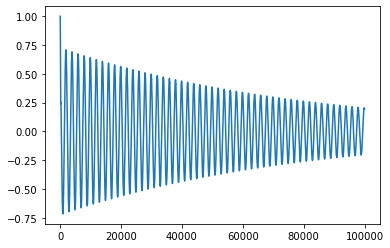

In [104]:
plt.plot(magn_1z)
#plt.plot(magn_0z)